In [49]:
import copy
import torchvision.models as models
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.utils import resample
import os
import numpy as np
import matplotlib.pyplot as plt

# simple dataset

In [50]:
### preparing Data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.255])

batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Grayscale(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Grayscale(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ])
}

data_path = 'D:\Master Project\model\model-1\C-vs-M3'
datasets = {x: ImageFolder(root=os.path.join(data_path, x), transform=data_transforms[x]) for x in ['train', 'val']}
print('datasets have been created')

dataloaders = {x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=2, shuffle=False, drop_last=True)
               for x in ['train', 'val']}
print('dataloaders have been created')

class_names = datasets['train'].classes
print(f'there are {len(class_names)} classes, and class names are {class_names}')

class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')


from collections import Counter

class_counts = Counter()

for phase in ['train', 'val']:
    for _, label in dataloaders[phase]:
        class_counts.update(label.tolist())

# show details
for label, count in class_counts.items():
    print(f'Class {label}: {count} instances')



your device is cuda
datasets have been created
dataloaders have been created
there are 2 classes, and class names are ['Corallococcus', 'Myxococcus']
Dataset sizes: {'train': 6640, 'val': 1600}
Class 0: 5184 instances
Class 1: 3040 instances


# Augmented dataset

In [51]:
from sklearn.utils import resample
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

class BalancedImageFolder(ImageFolder):
    def __init__(self, root, transform=None, target_samples_per_class=None, augment_transforms=None):
        super().__init__(root, transform=transform)
        self.target_samples_per_class = target_samples_per_class
        self.augment_transforms = augment_transforms

        # Identify the class counts and calculate oversampling indices
        class_counts = self._get_class_counts()
        self.indices = self._oversample_indices(class_counts)

    def _get_class_counts(self):
        class_counts = {}
        for _, label in self.samples:
            class_counts[label] = class_counts.get(label, 0) + 1
        return class_counts

    def _oversample_indices(self, class_counts):
        indices = list(range(len(self.samples)))
        if self.target_samples_per_class is None:
            return indices
        
        for label, count in class_counts.items():
            if count < self.target_samples_per_class:
                # Find indices of the current class
                current_class_indices = [i for i, (_, lbl) in enumerate(self.samples) if lbl == label]
                # Calculate the number of samples to oversample
                n_samples_to_add = self.target_samples_per_class - count
                # Perform oversampling
                oversampled_indices = resample(current_class_indices, replace=True, n_samples=n_samples_to_add, random_state=123)
                indices.extend(oversampled_indices)
        
        return indices

    def __getitem__(self, index):
        actual_index = self.indices[index]
        path, target = self.samples[actual_index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        
        # Apply augmentation transforms conditionally
        if isinstance(self.augment_transforms, dict):
            if target in self.augment_transforms:
                sample = self.augment_transforms[target](sample)
        elif isinstance(self.augment_transforms, transforms.Compose):
            sample = self.augment_transforms(sample)
        
        return sample, target

    def __len__(self):
        return len(self.indices)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')
# Example usage
# Define your device, batch size, and transforms as before
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomResizedCrop((224, 224)),
        # transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomResizedCrop((224, 224)),
        # transforms.Normalize(mean, std)
    ])
}

# Additional augmentations can now be set for each class specifically if desired
minority_augment_transforms = {
    1: transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
    ])
}

enhanced_augment_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(),
    transforms.RandomRotation(15),  # Slightly larger rotation
    transforms.RandomResizedCrop(340, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
])

class_specific_augment_transforms = {
    1: enhanced_augment_transforms,
    2: enhanced_augment_transforms# Only applying to class 1
    # You can add transformations for other classes as well
}
# Define your data_transforms and data_path as before

# Specify the target number of samples per class
target_samples_per_class = 3000
data_path = 'D:\Master Project\model\model-1\Corallo-vs-Myxo2'

# Creating datasets with BalancedImageFolder, now including target_samples_per_class
datasets = {
    x: BalancedImageFolder(
        root=os.path.join(data_path, x),
        transform=data_transforms[x],
        target_samples_per_class=target_samples_per_class if x == 'train' else None,  
        augment_transforms=enhanced_augment_transforms if x == 'train' else None,
    ) for x in ['train', 'val']
}
print('Datasets have been created.')

batch_size = 256

# Creating dataloaders
dataloaders = {
    x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=0, shuffle=True if x == 'train' else False, drop_last=True)
    for x in ['train', 'val']
}
print('Dataloaders have been created.')

# Get class names
class_names = datasets['train'].classes
print(f'There are {len(class_names)} classes, and class names are {class_names}')

# Count class instances
class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')

# from collections import Counter
# 
# class_counts = Counter()
# 
# for phase in ['train', 'val']:
#     for images, labels in dataloaders[phase]:
#         # Ensure labels are moved to CPU and converted to list if necessary
#         labels_list = labels.cpu().numpy().tolist() if device == 'cuda' else labels.tolist()
#         class_counts.update(labels_list)
# 
# # Show details
# for label, count in class_counts.items():
#     print(f'Class {label}: {count} instances')



your device is cuda
Datasets have been created.
Dataloaders have been created.
There are 2 classes, and class names are ['Corallococcus', 'Myxococcus']
Dataset sizes: {'train': 6000, 'val': 900}


In [102]:
# Custom dataset class to handle oversampling
class BalancedImageFolder(ImageFolder):
    def __init__(self, root, transform=None, minority_class=0, augment_transforms=None):
        super().__init__(root, transform=transform)
        self.minority_class = minority_class
        self.augment_transforms = augment_transforms

        # Identify the minority and majority classes and their counts
        class_counts = self._get_class_counts()
        self.max_count = max(class_counts.values())
        self.indices = self._oversample_indices(class_counts)

    def _get_class_counts(self):
        class_counts = {}
        for _, label in self.samples:
            class_counts[label] = class_counts.get(label, 0) + 1
        return class_counts

    def _oversample_indices(self, class_counts):
        # Oversample minority indices
        minority_indices = [i for i, (_, label) in enumerate(self.samples) if label == self.minority_class]
        required_samples = self.max_count - class_counts[self.minority_class]
        oversampled_minority_indices = resample(minority_indices, replace=True, n_samples=required_samples, random_state=123)
        return list(range(len(self.samples))) + oversampled_minority_indices

    def __getitem__(self, index):
        actual_index = self.indices[index]
        path, target = self.samples[actual_index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if target == self.minority_class and self.augment_transforms is not None:
            sample = self.augment_transforms(sample)
        return sample, target

    def __len__(self):
        return len(self.indices)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')

# # Data normalization mean and std
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.255])

# Batch size
batch_size = 32

# Additional augmentations for the minority class
minority_augment_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

# Standard data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomResizedCrop(224),
        # transforms.Normalize(mean, std),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        # transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.Normalize(mean, std),
    ]),
}

# Path to your data
data_path = 'D:\Master Project\model\model-1\Corallo-vs-Myxo2'

# Creating datasets with BalancedImageFolder
datasets = {
    x: BalancedImageFolder(
        root=os.path.join(data_path, x),
        transform=data_transforms[x],
        minority_class=1,  
        augment_transforms=minority_augment_transforms if x == 'train' else None,
    ) for x in ['train', 'val']
}
print('Datasets have been created.')

# Creating dataloaders
dataloaders = {
    x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=0, shuffle=True if x == 'train' else False, drop_last=True)
    for x in ['train', 'val']
}
print('Dataloaders have been created.')

# Get class names
class_names = datasets['train'].classes
print(f'There are {len(class_names)} classes, and class names are {class_names}')

# Count class instances
class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')

from collections import Counter

class_counts = Counter()

for phase in ['train', 'val']:
    for images, labels in dataloaders[phase]:
        # Ensure labels are moved to CPU and converted to list if necessary
        labels_list = labels.cpu().numpy().tolist() if device == 'cuda' else labels.tolist()
        class_counts.update(labels_list)

# Show details
for label, count in class_counts.items():
    print(f'Class {label}: {count} instances')



your device is cuda
Datasets have been created.
Dataloaders have been created.
There are 2 classes, and class names are ['Corallococcus', 'Myxococcus']
Dataset sizes: {'train': 4698, 'val': 1134}
Class 1: 2886 instances
Class 0: 2906 instances


## simple cnn model

In [6]:
from torchvision.utils import save_image
import os

def save_augmented_dataset(dataset, save_dir):
    """
    Saves the augmented images from the dataset to the specified directory.
    
    Args:
    - dataset: The dataset object (instance of BalancedImageFolder or similar).
    - save_dir (str): The base directory where augmented images will be saved.
    """
    for i in range(len(dataset)):
        # Extract augmented image and label
        img, label = dataset[i]
        
        # Construct path for saving image: save_dir/class_name/img_name.png
        class_name = dataset.classes[label]
        class_dir = os.path.join(save_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)  # Create class directory if not exists
        
        # Construct a unique filename for each image
        img_name = f"{i}_{class_name}.png"
        
        # Save image
        save_path = os.path.join(class_dir, img_name)
        save_image(img, save_path)

# Specify the directory to save augmented images
augmented_data_path = 'path/to/your/augmented_dataset'

# Call the function for your training dataset
# Note: Only use the training dataset if you only want to augment the training data
save_augmented_dataset(datasets['train'], augmented_data_path)

print('Augmented images have been saved.')


C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000028BABE15AB0>
Traceback (most recent call last):
  File "C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 

KeyboardInterrupt: 

In [15]:
from torchsummary import summary


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(512 * 11 * 11, 2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.relu(self.conv5(x))
        x = x.view(-1, 512 * 11 * 11)
        x = nn.functional.relu(self.fc1(x))
        return x
    



model = SimpleCNN()
input_size = (3, 340, 340)
model = model.to(device)
summary(model, input_size)
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 170, 170]             896
            Conv2d-2           [-1, 64, 85, 85]          18,496
            Conv2d-3          [-1, 128, 43, 43]          73,856
            Conv2d-4          [-1, 256, 22, 22]         295,168
            Conv2d-5          [-1, 512, 11, 11]       1,180,160
            Linear-6                    [-1, 2]         123,906
Total params: 1,692,482
Trainable params: 1,692,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.32
Forward/backward pass size (MB): 13.81
Params size (MB): 6.46
Estimated Total Size (MB): 21.59
----------------------------------------------------------------
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


## pretrained model: efficientnet_v2_s

In [11]:
import torchvision.models as models
import torch.nn as nn

model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
# for param in model.parameters():
#     param.requires_grad = False
model_params = 0
for idx, layer in enumerate(model.features):
    layer_param = 0
    for param in layer.parameters():
        param.requires_grad = False
        layer_param += 1
    print(f'layer {idx+1} params: {layer_param}')
    model_params += layer_param
print(f'model params: {model_params}')


last_layer = nn.Linear(in_features=model.classifier[6].in_features, out_features=len(class_names), bias=True)


model.classifier[6] = last_layer
model.classifier

layer 1 params: 2
layer 2 params: 0
layer 3 params: 2
layer 4 params: 0
layer 5 params: 0
layer 6 params: 2
layer 7 params: 0
layer 8 params: 2
layer 9 params: 0
layer 10 params: 0
layer 11 params: 2
layer 12 params: 0
layer 13 params: 2
layer 14 params: 0
layer 15 params: 2
layer 16 params: 0
layer 17 params: 0
layer 18 params: 2
layer 19 params: 0
layer 20 params: 2
layer 21 params: 0
layer 22 params: 2
layer 23 params: 0
layer 24 params: 0
layer 25 params: 2
layer 26 params: 0
layer 27 params: 2
layer 28 params: 0
layer 29 params: 2
layer 30 params: 0
layer 31 params: 0
model params: 26


NameError: name 'class_names' is not defined

In [53]:
import torchvision.models as models
import torch.nn as nn

model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
# print(model.features[0][0])
first_conv_layer = nn.Sequential(nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=0, dilation=1, groups=1, bias=True),
                                 nn.Conv2d(3, 24, kernel_size=3, stride=2, padding=1, bias=False))
  
model.features[0][0] = first_conv_layer
# print(model.features[0][0])
model_params = 0
for idx, layer in enumerate(model.features[0: -2]):
    layer_param = 0
    for param in layer.parameters():
        param.requires_grad = False
        layer_param += 1
    print(f'layer {idx+1} params: {layer_param}')
    model_params += layer_param
print(f'model params: {model_params}')


# print(model.classifier)
last_layer = nn.Linear(in_features=model.classifier[1].in_features, out_features=len(class_names), bias=True)


model.classifier[1] = last_layer
model.classifier

layer 1 params: 5
layer 2 params: 6
layer 3 params: 24
layer 4 params: 24
layer 5 params: 78
layer 6 params: 117
model params: 254


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

In [27]:
import torchvision.models as models
import torch.nn as nn

model = models.swin_v2_s(weights=models.Swin_V2_S_Weights.DEFAULT)
# print(model)

model_params = 0
for idx, layer in enumerate(model.features):
    layer_param = 0
    for param in layer.parameters():
        param.requires_grad = False
        layer_param += 1
    print(f'layer {idx+1} params: {layer_param}')
    model_params += layer_param
print(f'model params: {model_params}')

last_layer = nn.Linear(in_features=model.head.in_features, out_features=len(class_names), bias=True)


model.head = last_layer
model.head

layer 1 params: 4
layer 2 params: 32
layer 3 params: 3
layer 4 params: 32
layer 5 params: 3
layer 6 params: 288
layer 7 params: 3
layer 8 params: 32
model params: 397


NameError: name 'class_names' is not defined

In [28]:
model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
# print(model)

model_params = 0
for idx, layer in enumerate(model.features):
    layer_param = 0
    for param in layer.parameters():
        param.requires_grad = False
        layer_param += 1
    print(f'layer {idx+1} params: {layer_param}')
    model_params += layer_param
print(f'model params: {model_params}')

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to C:\Users\Mahdiar/.cache\torch\hub\checkpoints\efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [06:08<00:00, 592kB/s]  


layer 1 params: 3
layer 2 params: 9
layer 3 params: 30
layer 4 params: 30
layer 5 params: 91
layer 6 params: 182
layer 7 params: 234
layer 8 params: 65
layer 9 params: 3
model params: 647


In [41]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(model.layer4.children())


layer_param = 0
for param in model.layer1.children():
    param.requires_grad = False
    layer_param += 1
# print(f'layer {idx+1} params: {layer_param}')
print(f'model params: {model_params}')

<generator object Module.children at 0x000002662520FA70>
model params: 0


In [46]:
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
print(model)


layer_param = 0
for param in model.Conv2d_2b_3x3.parameters():
    param.requires_grad = False
    layer_param += 1
# print(f'layer {idx+1} params: {layer_param}')
print(f'model params: {model_params}')

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [48]:
model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)
print(model)

model_params = 0
for idx, layer in enumerate(model.features):
    layer_param = 0
    for param in layer.parameters():
        param.requires_grad = False
        layer_param += 1
    print(f'layer {idx+1} params: {layer_param}')
    model_params += layer_param
print(f'model params: {model_params}')

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [54]:
from datetime import datetime
from easydict import EasyDict


# train function 
def train_model(model, criterion, optimizer, dataloaders, datasets, epoch_num=25):
    acc_list = EasyDict({'train': [], 'val': []})
    loss_list = EasyDict({'train': [], 'val': []})

    # Copy the best model weights for loading at the End
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    # Iterating over epochs
    for epoch in range(1, epoch_num + 1):
        print(f'Epoch {epoch}/{epoch_num}:')

        # Each epoch has two phase Train and Validation
        for phase in ['train', 'val']:
            s0 = datetime.now()
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # For calculating Loss and Accuracy at the end of epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Iterating over batches and data for training and validation
            for idx, batch in enumerate(dataloaders[phase], 0):
                inputs, labels = batch

                # Transfer data and labels to CUDA if is available
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, predictions = torch.max(outputs, 1)

                    # Back Propagation and updating weights
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            # Calculating Accuracy and Loss per phase
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = running_corrects.double() / len(datasets[phase])

            # Show epoch details
            delta = datetime.now() - s0
            print(f'{phase.capitalize()} Accuracy: {epoch_accuracy:.4f} | Loss: {epoch_loss:.4f} | time: {delta}')

            # Copy the model weights if its better
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best model weights updated!')

            # Save Loss and accuracy
            acc_list[phase].append(epoch_accuracy)
            loss_list[phase].append(epoch_loss)
        print()

    print(f'Best Accuracy: {best_accuracy:.4f}')

    # Loading best model weights 
    model.load_state_dict(best_model_wts)
    return model, acc_list, loss_list

In [55]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
model = model.to(device)
print(model)

# train model
model, acc_lists, loss_lists = train_model(model, criterion, optimizer, dataloaders, datasets, epoch_num=100)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Sequential(
        (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
        (1): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Accuracy: 0.6403 | Loss: 0.5964 | time: 0:05:38.485166
Val Accuracy: 0.2233 | Loss: 1.2046 | time: 0:00:11.117992
Best model weights updated!

Epoch 2/100:
Train Accuracy: 0.6833 | Loss: 0.5509 | time: 0:05:00.571535
Val Accuracy: 0.4667 | Loss: 0.6221 | time: 0:00:10.226175
Best model weights updated!

Epoch 3/100:
Train Accuracy: 0.6963 | Loss: 0.5299 | time: 0:05:31.248795
Val Accuracy: 0.4811 | Loss: 0.5437 | time: 0:00:09.770313
Best model weights updated!

Epoch 4/100:
Train Accuracy: 0.7053 | Loss: 0.5173 | time: 0:05:06.576825
Val Accuracy: 0.5767 | Loss: 0.5594 | time: 0:00:10.360524
Best model weights updated!

Epoch 5/100:
Train Accuracy: 0.7088 | Loss: 0.5093 | time: 0:05:10.021246
Val Accuracy: 0.4500 | Loss: 0.6314 | time: 0:00:09.516141

Epoch 6/100:
Train Accuracy: 0.7100 | Loss: 0.5126 | time: 0:05:09.763256
Val Accuracy: 0.5433 | Loss: 0.6326 | time: 0:00:09.577718

Epoch 7/100:
Train Accuracy: 0.7115 | Loss: 0.5045 | time: 0:05:10.519912
Val Accuracy: 0.5789 | 

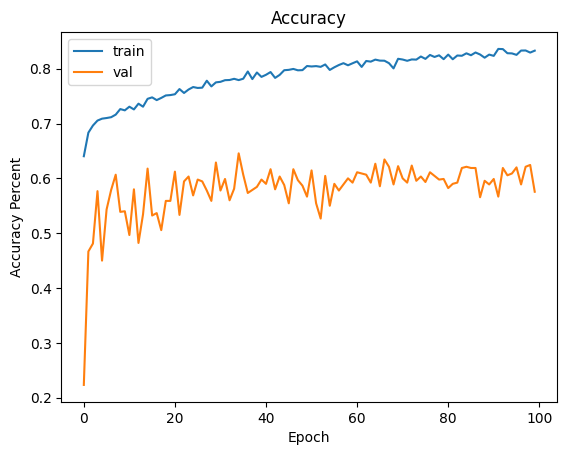

<Figure size 640x480 with 0 Axes>

In [56]:
plt.plot([a.cpu() for a in acc_lists.train], label='train')
plt.plot([a.cpu() for a in acc_lists.val], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()
plt.savefig('accuracy.jpg')

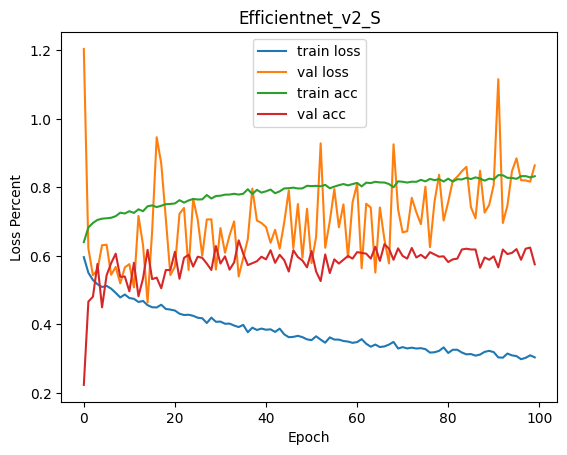

<Figure size 640x480 with 0 Axes>

In [61]:
plt.plot([a for a in loss_lists.train], label='train loss')
plt.plot([a for a in loss_lists.val], label='val loss')
plt.plot([a.cpu() for a in acc_lists.train], label='train acc')
plt.plot([a.cpu() for a in acc_lists.val], label='val acc')
plt.title('Efficientnet_v2_S')
plt.xlabel('Epoch')
plt.ylabel('Loss Percent')
plt.legend()
plt.show()
plt.savefig('loss.jpg')


# Visualize model

C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


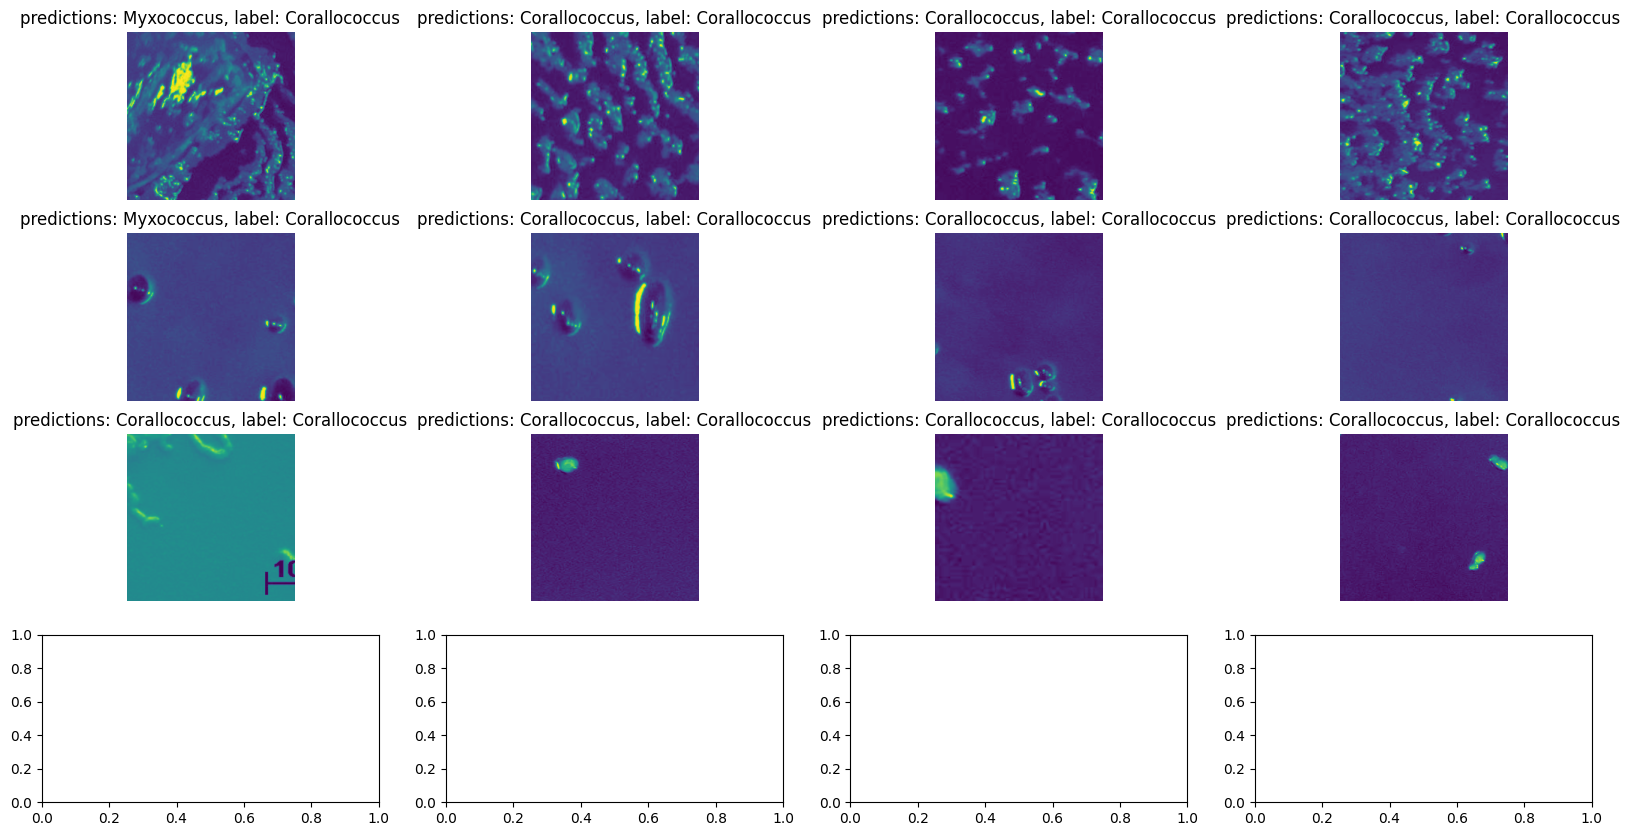

In [58]:
def visualize_model(model):
    model.eval()
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                # img = std * img + mean
                img = np.clip(img, 0, 1)
                axes[i][j].axis('off')
                axes[i][j].set_title(
                    f'predictions: {class_names[predictions[j]]}, label: {class_names[labels[j]]}'
                )
                axes[i][j].imshow(img)
                if j == ncols - 1:
                    break
            if i == nrows - 1:
                break
    plt.savefig('vis.jpg')


visualize_model(model)

In [59]:
torch.save(model, 'efficientnetv2s_model.pth')
print('model Saved.')

model Saved.
